In [1]:
import networkx as nx
import matplotlib
%matplotlib inline
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import random
import time

In [ ]:
# ONLY IF COLAB 
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/src/NetworkSyncCapstone

In [2]:
import sys
sys.path.append('./Metropolis/')
sys.path.append('./src')

In [ ]:
# ANALYSINg RESULTS  FROM A WHOLE RUN
#-----------------------

#-------------------------------------------------------------------
# Analyse 'r_ER-100-p0.1-InDegree-NoSelf-RandomW'
#--------------------------------------------------------------------

from metropolisHastings import loadFromPickle

pickleroot = './data/r_ER-100-p0.1-InDegree-NoSelf-RandomW'

result = loadFromPickle(pickleroot=pickleroot, measurenames=['discreteSigma2Analytical','weighted_average_clustering'], gml=False, errorbar=True, title=None, figsize=None)

    # name like r_Gcatu_TSE_up_beta_3000.pkl
    #     E.G. PICKLEROOT='r_Gcatu_TSE_'

In [4]:
# LOADING A BETA
#-------------------
from pickleUtil import pickleLoad

result_beta = pickleLoad('r_FixIn-100-DegIn2-InDegree-NoSelf-FixedW_up_beta_500', './data')
result_beta

Loading object r_FixIn-100-DegIn2-InDegree-NoSelf-FixedW_up_beta_500 from pickle file ./data/r_FixIn-100-DegIn2-InDegree-NoSelf-FixedW_up_beta_500.pkl


{'samples': {'N': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
  'L': [200, 200, 200, 200, 200, 200, 200, 200, 200, 200],
  'average_degree': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0],
  'sigma_z': [1.7944358444926358,
   1.6124515496597103,
   1.7832554500127007,
   1.8547236990991411,
   1.8493242008906934,
   1.8601075237738276,
   1.8814887722226776,
   1.9697715603592207,
   1.897366596101028,
   1.9697715603592207],
  'weighted_average_clustering': [0.03816666666666666,
   0.029904761904761896,
   0.03844841269841269,
   0.03659126984126985,
   0.0414920634920635,
   0.02991666666666666,
   0.03136111111111111,
   0.034888888888888886,
   0.024499999999999997,
   0.03383333333333333],
  'discreteSigma2Analytical': [2224.4185418181964,
   2502.09792993164,
   2502.119303662109,
   2502.2008484374996,
   2502.2168984375003,
   2502.289216406249,
   2502.3077898437496,
   2502.3028562499994,
   2502.3493742187493,
   2502.3719468749996],
  'average_clustering': [0.03

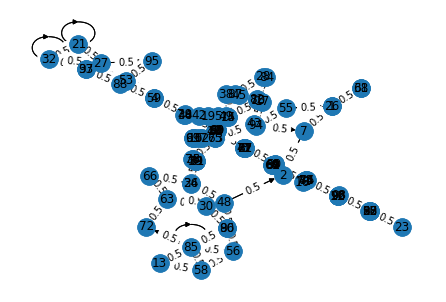

In [5]:
G = result_beta['lastnet']
layout = nx.kamada_kawai_layout(G)
nx.draw(G, layout)
nx.draw_networkx(G, pos=layout)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)
plt.show()

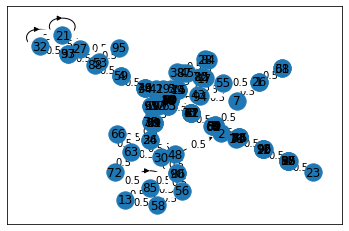

In [6]:
from gvisu import drawCurvedEdgesGraph

drawCurvedEdgesGraph(G)

In [7]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [1]:
import torch
torch.cuda.is_available()

False

In [ ]:
  #-------------------------------------------------------------------
# Analyse 'r_ER-100-p0.1-InDegree-NoSelf-RandomW'
#--------------------------------------------------------------------

from metropolisHastings import loadFromPickle

pickleroot = './data/FixIn-100-DegIn8-InDegree-NoSelf-FixedW-002'

result = loadFromPickle(pickleroot=pickleroot, measurenames=['discreteSigma2Analytical','weighted_average_clustering'], gml=False, errorbar=True, title=None, figsize=None)

    # name like r_Gcatu_TSE_up_beta_3000.pkl
    #     E.G. PICKLEROOT='r_Gcatu_TSE_'

In [116]:
import copy
import networkx as nx
import numpy as np
import random
import pandas as pd
import re
import pickle
from pathlib import Path
from pickleUtil import pickleLoad

# def loadSamplesFromPickle(experiment_name, datafolder='./data', constraint_name='discreteSigma2Analytical'):

#     # name like r_Gcatu_TSE_up_beta_3000.pkl
#     baseUri=Path(datafolder)

#     pklFiles=[x for x in baseUri.glob('**/' + experiment_name + '*.pkl')]

#     if pklFiles==[]:
#         print(f'No files found here {datafolder}/{experiment_name}*.pkl')
#         return

#     patternBeta = r"beta_(-?[0-9]*)\.pkl"
#     patternUp = r"_up_"
#     patternStartNet = r"StartNet\.pkl"
#     patternBurnin = r"_burnin_(-?[0-9]*)\.pkl"

#     data  ={ 'beta': [], 'up': [], 'g': [], 'time':[], 'file':[], 'experiment':[], 'comment':[], constraint_name: []}
#     #dataDown={ 'beta': [], 'up': [], 'g': [], 'time':[], 'file':[], 'experiment':[], 'comment':[]}

#     for i, fn in enumerate(pklFiles):
        
#         print('######################################################################################################')
#         print(f'Processing file {i}, {fn}')
#         print('######################################################################################################')
        
#         # Saving initial network 
#         if re.search(patternStartNet, fn.name)!= None:
#             startNet=True
#             result=pickleLoad(str(fn.stem), str(fn.parents[0]), silent=False)
#             data['beta'].append(-1)
#             data['up'].append(True)
#             data['g'].append(result)
#             data['time'].append(-1)
#             data['file'].append(fn)
#             data['experiment'].append(experiment_name)
#             data['comment'].append('startNet')
#             data[constraint_name].append(-1)
#             continue
        
#         comment=''
#         if re.search(patternBurnin, fn.name)!=None:
#         # Reading burning results
#             print('Reading burnin file')
#             beta = int(re.search(patternBurnin, fn.name).group(1))
#             up=True
#             comment='burnin'
#         else:
#         # Reading standard result
#             beta=int(re.search(patternBeta, fn.name).group(1))
#             up=False
#             if re.search(patternUp, fn.name)!= None:
#                 up=True
#             else:
#                 up=False

#         #loading pickle file
#         result=pickleLoad(str(fn.stem), str(fn.parents[0]), silent=True)

#         for i, (sample, constraint_measure) in enumerate(zip(result['samples']['g'], result['samples'][constraint_name])):

#             print(i, sample, constraint_measure)
#             data['beta'].append(beta)
#             data['up'].append(up)
#             data['g'].append(sample)
#             data[constraint_name].append(constraint_measure)
#             data['time'].append(i)
#             data['file'].append(fn)
#             data['experiment'].append(experiment_name)
#             data['comment'].append('')

#     df = pd.DataFrame.from_dict(data)
#     df = df.sort_values(by=['beta', 'time'])
            
#     return df

In [1]:

from metropolisHastings import loadSamplesFromPickle
df_up = loadSamplesFromPickle('r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW', datafolder='./data')

Processing file 0, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-002_up_beta_100004.pkl
Processing file 1, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-002_burnin_100000.pkl
Reading burnin file
Processing file 2, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-002_up_beta_100003.pkl
Processing file 3, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-001_down_beta_-100001.pkl
Processing file 4, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-001_down_beta_-100003.pkl
Processing file 5, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-001_burnin_-100000.pkl
Reading burnin file
Processing file 6, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-001_up_beta_4.pkl
Processing file 7, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-001_up_beta_5.pkl
Processing file 8, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-001_up_beta_-100000.pkl
Processing file 9, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-002-StartNet.pkl
Loading object r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-002-StartNet from pickl

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


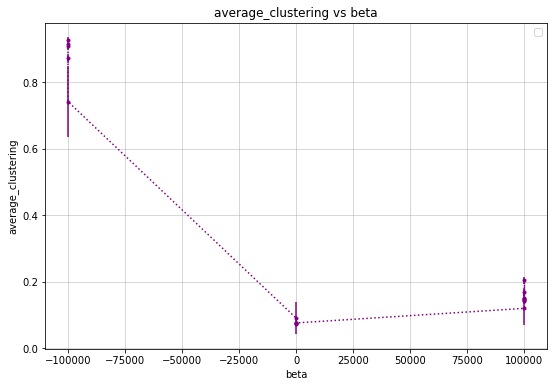

In [2]:
import networkx as nx
from metropolisHastings import analyzeMetropolisHastingsGraphs
df, dfm = analyzeMetropolisHastingsGraphs(df_up, nx.average_clustering)

<AxesSubplot:xlabel='beta'>

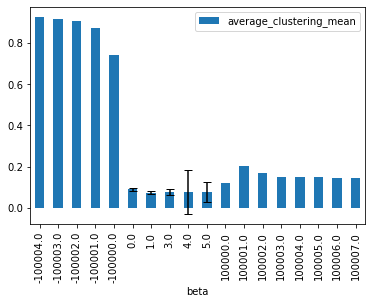

In [5]:
dfm.keys()

dfm.plot(x='beta', y='average_clustering_mean', yerr=dfm['average_clustering_std'], kind='bar', capsize=4, rot=90)

<AxesSubplot:xlabel='beta'>

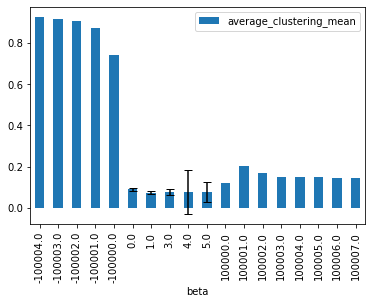

In [6]:
dfm.plot(x='beta', y='average_clustering_mean', yerr=dfm['average_clustering_std'], kind='bar', capsize=4, rot=90)

<AxesSubplot:xlabel='beta', ylabel='average_clustering'>

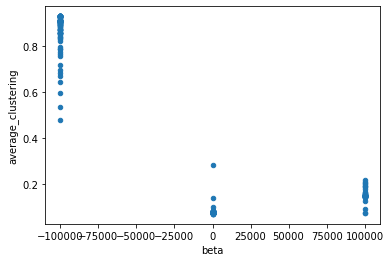

In [7]:
df.plot(x='beta', y='average_clustering', kind='scatter')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


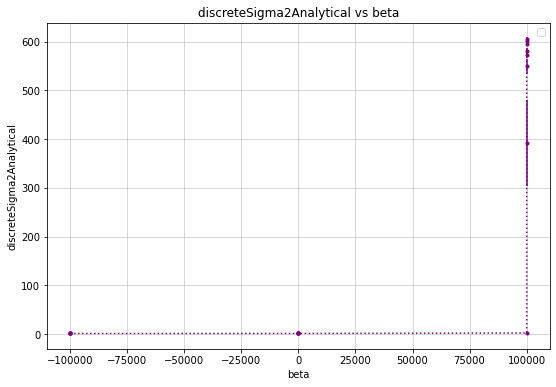

In [7]:
from networkSigma import discreteSigma2Analytical
df, dfm2 = analyzeMetropolisHastingsGraphs(df_up, discreteSigma2Analytical)

In [17]:
n1 = 10

print(f'{n1:#04}')

0010


AttributeError: 'AxesImage' object has no property 'show'

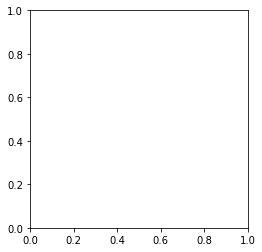

In [18]:
import sys
sys.path.append('./Metropolis/')
sys.path.append('./src')
from gvisu import drawMatrix



kwargs = { 'vmin': 0, 'vmax': 0.3 }

for i, row in df.sort_values(by=['beta', 'time'], ascending=True).iterrows():
    drawMatrix(row.g, experiment_title=f'r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-{row.beta:#07}-{row.time:#03}', folder='./images', show=True, **kwargs)
